## Load replay buffer

In [1]:
import pickle
import torch
from src.utils import load_replay_buffer
from src.learning.symmetry_discovery.differential.kernel_approx import KernelFrameEstimator

TASK_NAME="sac_circle_rotation_task_0"
N_SAMPLES:int=50_000
KERNEL_DIM=1
EPSILON_BALL = 0.005
EPSILON_LEVEL_SET = 0.0025

LEARN_KERNEL_BASES: bool=False
replay_buffer_name:str=TASK_NAME+"_replay_buffer.pkl"
kernel_bases_name:str=TASK_NAME+"_kernel_bases.pkl"

replay_buffer_task_1= load_replay_buffer(replay_buffer_name, N_steps=N_SAMPLES)

next_ps=replay_buffer_task_1["next_observations"]
ns=replay_buffer_task_1["rewards"]



if LEARN_KERNEL_BASES:
    frameestimator= KernelFrameEstimator(ps=next_ps, kernel_dim=KERNEL_DIM,ns=ns, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)
    frameestimator.compute()
    frameestimator.save(kernel_bases_name)

else:
    # for inference only need ps and dimension of kernel.
    frameestimator=KernelFrameEstimator(ps=next_ps, kernel_dim=KERNEL_DIM)
    with open(kernel_bases_name, 'rb') as f:
        kernel_samples = pickle.load(f)
        frameestimator.set_frame(frame=kernel_samples)

# Evaluate frame estimator
p_query=torch.randn((2))
frameestimator.setup_evaluation(k=10, bandwidth=0.5)
frameestimator.evaluate(p_query, k=10, bandwidth=0.5)

2025-07-02 13:51:21.143897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.
INFO:faiss:Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


tensor([[-0.9599],
        [ 0.2803]])

## Extrapolate via KDE

In [6]:
import numpy as np
num_points = 500
x = np.random.uniform(-0.75, 0, num_points)
y = np.random.uniform(0, 0.75, num_points)
points = np.stack([x, y], axis=1)

# Feed points into smooth_subspace and collect vectors
vectors = []
for point in points:
    p_query = torch.tensor(point, dtype=torch.float32)
    V_smooth = frameestimator.evaluate(p_query, k=10, bandwidth=0.5)
    vectors.append(V_smooth.numpy())  # Extract the first row of the smoothed subspace

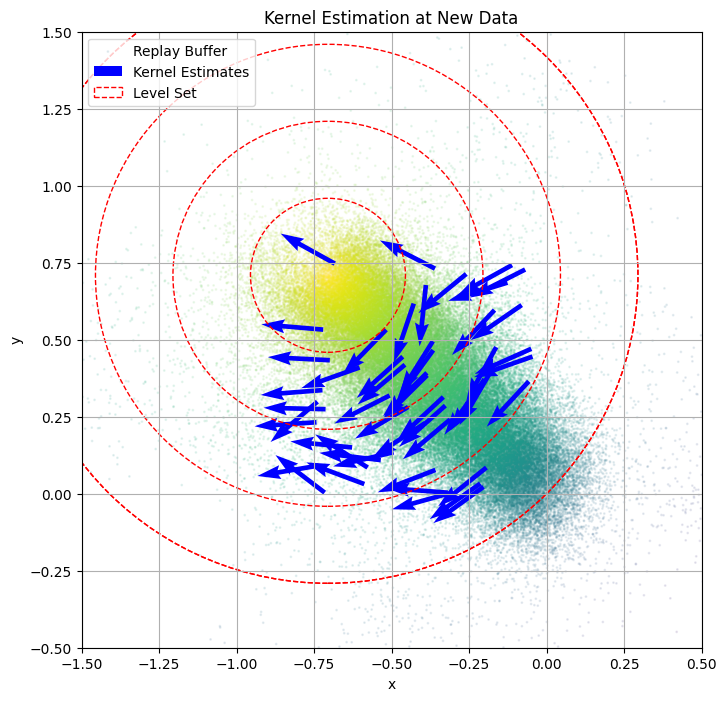

In [3]:
import numpy as np

import matplotlib.pyplot as plt

# Sample 50 points uniformly in the 2D plane

num_points = 50
x = np.random.uniform(-0.75, 0, num_points)
y = np.random.uniform(0, 0.75, num_points)
points = np.stack([x, y], axis=1)

# Feed points into smooth_subspace and collect vectors
vectors = []
for point in points:
    p_query = torch.tensor(point, dtype=torch.float32)
    V_smooth = frameestimator.evaluate(p_query, k=10, bandwidth=0.5)
    vectors.append(V_smooth.numpy())  # Extract the first row of the smoothed subspace

vectors = np.array(vectors)
# Add circles around the specified goal point

# Plot points and vectors using quiver
plt.figure(figsize=(8, 8))
plt.scatter(next_ps[:, 0], next_ps[:, 1], c=ns, s=1, alpha=0.1, label="Replay Buffer")
plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1], angles='xy', scale_units='xy', scale=5, color='blue', label="Kernel Estimates")

goal = np.array([-0.70506063, 0.70914702])
circle_radii = [0.25, 0.5, 0.75, 1]
for radius in circle_radii:
    circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--', label="Level Set")
plt.gca().add_artist(circle)

plt.xlim(-1.5, 0.5)
plt.ylim(-0.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Kernel Estimation at New Data')
plt.grid()
plt.show()

## Matrix logarithm

In [4]:
import scipy.linalg
import torch

def adjoint(A, E, f):
    A_H = A.mH.to(E.dtype)
    n = A.size(0)
    M = torch.zeros(2*n, 2*n, dtype=E.dtype, device=E.device)
    M[:n, :n] = A_H
    M[n:, n:] = A_H
    M[:n, n:] = E
    return f(M)[:n, n:].to(A.dtype)

def logm_scipy(A):
    return torch.from_numpy(scipy.linalg.logm(A.cpu(), disp=False)[0]).to(A.device)

class Logm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A):
        assert A.ndim == 2 and A.size(0) == A.size(1)  # Square matrix
        assert A.dtype in (torch.float32, torch.float64, torch.complex64, torch.complex128)
        ctx.save_for_backward(A)
        return logm_scipy(A)

    @staticmethod
    def backward(ctx, G):
        A, = ctx.saved_tensors
        return adjoint(A, G, logm_scipy)

logm = Logm.apply

A = torch.rand(3, 3, dtype=torch.float64, requires_grad=True)
torch.autograd.gradcheck(logm, A)
A = torch.rand(3, 3, dtype=torch.complex128, requires_grad=True)
torch.autograd.gradcheck(logm, A)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_80387/1329727610.py:11: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_290u7eqnqq/croot/pytorch-select_1730848721858/work/aten/src/ATen/native/Copy.cpp:300.)
  return f(M)[:n, n:].to(A.dtype)


GradcheckError: While considering the imaginary part of complex outputs only, Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[-0.6990, -0.0481, -0.1971, -0.1049,  0.1195,  0.2761, -0.1716,  0.2484,
          0.5795],
        [-0.1049, -0.6510, -0.0701,  0.1294, -0.3043,  0.1971,  0.2723, -0.5843,
          0.4092],
        [-0.1716, -0.0777, -0.7759,  0.2723,  0.1284, -0.0027,  0.5701,  0.2687,
          0.0431],
        [-0.0481,  0.1073,  0.2533, -0.6510, -0.2251, -0.6190, -0.0777,  0.1169,
          0.2732],
        [ 0.1195, -0.2251,  0.1764, -0.3043, -0.3121, -0.3610,  0.1284, -0.2719,
          0.1926],
        [ 0.2484,  0.1169,  0.0459, -0.5843, -0.2719, -0.8846,  0.2687,  0.1266,
          0.0235],
        [-0.1971,  0.2533,  0.5884, -0.0701,  0.1764,  0.4176, -0.7759,  0.0459,
          0.0207],
        [ 0.2761, -0.6190,  0.4176,  0.1971, -0.3610,  0.2900, -0.0027, -0.8846,
          0.0849],
        [ 0.5795,  0.2732,  0.0207,  0.4092,  0.1926,  0.0849,  0.0431,  0.0235,
         -0.7721]], dtype=torch.float64)
analytical:tensor([[ 0.6990,  0.0481,  0.1971,  0.1049, -0.1195, -0.2761,  0.1716, -0.2484,
         -0.5795],
        [ 0.1049,  0.6510,  0.0701, -0.1294,  0.3043, -0.1971, -0.2723,  0.5843,
         -0.4092],
        [ 0.1716,  0.0777,  0.7759, -0.2723, -0.1284,  0.0027, -0.5701, -0.2687,
         -0.0431],
        [ 0.0481, -0.1073, -0.2533,  0.6510,  0.2251,  0.6190,  0.0777, -0.1169,
         -0.2732],
        [-0.1195,  0.2251, -0.1764,  0.3043,  0.3121,  0.3610, -0.1284,  0.2719,
         -0.1926],
        [-0.2484, -0.1169, -0.0459,  0.5843,  0.2719,  0.8846, -0.2687, -0.1266,
         -0.0235],
        [ 0.1971, -0.2533, -0.5884,  0.0701, -0.1764, -0.4176,  0.7759, -0.0459,
         -0.0207],
        [-0.2761,  0.6190, -0.4176, -0.1971,  0.3610, -0.2900,  0.0027,  0.8846,
         -0.0849],
        [-0.5795, -0.2732, -0.0207, -0.4092, -0.1926, -0.0849, -0.0431, -0.0235,
          0.7721]], dtype=torch.float64)
